---
CSC 268 Homework #2
---

The goal of this assignment is to experiment with a variety of different image transformations.  By the end of this work you should feel comfortable with transformation matrices, image resampling, and interpolation.

Collaboration: Bella Falbo


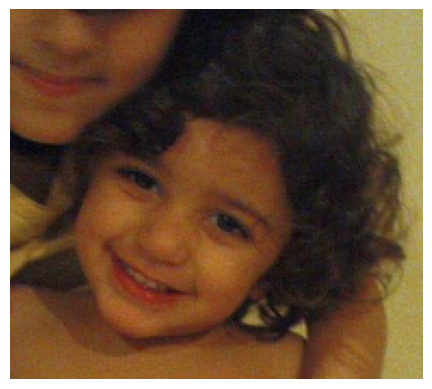

(171, 191, 3)
float64


In [ ]:
import cv2 as cv
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='gray')
import math

def imshow(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()
nooni = cv.imread('nooni.png',cv.IMREAD_COLOR)[0::4,0::4,[2,1,0]]/255.0

checkboard = cv.imread('checkerboard.png',cv.IMREAD_COLOR)[0::4,0::4,[2,1,0]]/255.0

imshow(nooni)
print(nooni.shape)
print(nooni.dtype)


### Part One:  Interpolation

For this section, pick an RGB image of your choice and scale it down to fewer than 1000 pixels while preserving the aspect ratio (width:height).  For example, a 3000x5000 image might be rescaled to 24x40, while a 4000x2500 image might be rescaled to 40x25.  You may use the OpenCV `resize` function for this step, with interpolation mode `INTER_AREA`.

Next, you will scale the image back up to its original dimensions via interpolation.  For this part you should rely on SciPy's `RegularGridInterpolator`.  (As an extension, you could try computing the interpolation yourself from basic array arithmetic.)  You should create and display <s>three</s> two versions:  one based upon nearest neighbor interpolation, on using bilinear, <s>and one using bicubic</s>.  Title each one appropriately.  Finally, examine them carefully and describe the differences you see between them.  If you can't see any differences, try cropping out a small area and display it zoomed in.

_Note:  at the moment there appears to be an issue with cubic interpolation and `RegularGridInterpolator`, so this portion of the assignment is optional.  It can be done layer by layer using SciPy's `RectBivariateSpline` interpolator._

In [ ]:
# To scale down the image, step 1
def change_size(img, scale):
  w = int(img.shape[1] * scale /100)
  h = int(img.shape[0] * scale /100)
  dim = (w, h)
  scaled = cv.resize(img, dim, interpolation = cv.INTER_AREA)
  return scaled

# To extract points of images
def points(shape):
  n_rows,n_cols,n_clr = shape
  px = np.array(range(n_cols))
  py = np.array(range(n_rows))
  return py, px

# To make a meshgrid, the size of a given shape
def g_points(shape):
  n_rows,n_cols,n_clr = shape
  px = np.array(range(n_cols))
  py = np.array(range(n_rows))
  pxg,pyg = np.meshgrid(px, py, indexing='xy')
  return pyg, pxg

# To create t vetors (ty, tx), and edit the t vectors to be rotated, zoomed in, or zoomed out
def tvec(pyg, pxg, theta, scale):
  pvec = np.stack((pxg.ravel(),pyg.ravel(),np.ones(pxg.size,dtype=np.float64)))
  # small scale numbers zoom in while large scale numbers zoom out 
  R = np.array([[math.cos(theta),-math.sin(theta),0],[math.sin(theta),math.cos(theta),0],[0,0,1]]) * scale #theta is to rotate the vectors
  tvec = np.matmul(R,pvec)
  tx = tvec[0,:].reshape(pxg.shape)
  ty = tvec[1,:].reshape(pyg.shape)
  return ty, tx

# blockbox to interpate images
# points -> points of images, data -> image, func -> preferred method of interpolation, ty tx -> manipulated t vectors 
def interp(points, data, func, ty, tx):
  interp =  RegularGridInterpolator(points, data, method=func, bounds_error=False, fill_value=0.0)
  return interp((ty, tx))



Scaled Down:



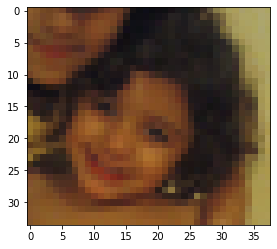


Linear:



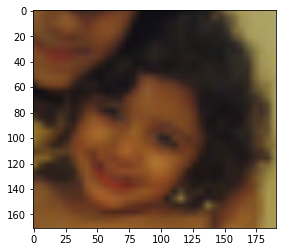


Nearest:



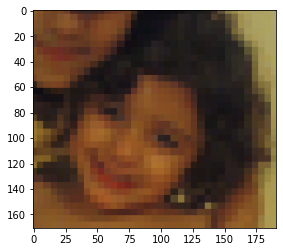


Cubic



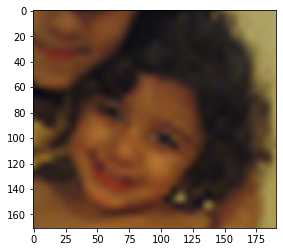

In [ ]:
scaled_nooni = change_size(nooni, 20) #resizing 

py, px = points(scaled_nooni.shape) #points of scaled_nooni

pyg, pxg = g_points(nooni.shape) #meshgrid points of nooni, the original image

ty, tx = tvec(pyg, pxg, 0, 0.19) #t-vectors, theta=0, scale is 0.19

print("\nScaled Down:\n")
imshow(scaled_nooni)
nooni_linear = interp((py, px), scaled_nooni, 'linear', ty, tx)

print("\nLinear:\n")
imshow(nooni_linear) # less detailed than nooni_cubic but it has a faster running time compared to nooni_cubic. It could be useful with running time constraints

nooni_near = interp((py, px), scaled_nooni, 'nearest', ty, tx)
print("\nNearest:\n") # looks very similar to scaled_nooni but with more pixels. The least detailed 
imshow(nooni_near)

nooni_cubic = interp((py, px), scaled_nooni, 'cubic', ty, tx)
print("\nCubic\n")  # has the best details out of the three methods and a better saturation. 
imshow(nooni_cubic)


### Part Two: Resampling Filters

For this section you will create a selection of four preset image filters.  Pick at least three of the ideas below to try.  If you wish, you may come up with and develop your own idea for the fourth instead of following the ideas below.  Each filter should be implemented as a function that takes an RGB image together with optional arguments, and returns the transformed image.

Here is a rough outline of the procedure for all but the keystone correction item:
1. Generate a grid of x and y points for your image.  For some, you will also need to compute [polar coordinates](https://mathinsight.org/polar_coordinates) using Numpy's `sqrt` and `arctan2` functions.
2. Create a `RegularGridInterpolator` using the grid points as coordinates and the image intensities as the function to be estimated.
3. Apply some alteration to the coordinates according to the effect you are trying to achieve to generate new x and y points.
4. Use the interpolator to get the array of values computed at the new points.  This is the image you will return.

<img src="hw2im/tv_check.png" height="100" width="160" alt="TV Interference" title="TV Interference" style="float: right; clear:right;">

**TV Interference** For this filter, sampled points will keep their y position intact.  However, their x position will be shifted according to a sine function of the y.  The period and amplitude of the sine function should be optional parameters; by default set them so that around five wavelengths are visible, and the amplitude is one quarter the wavelength.  

<img src="hw2im/ripple_check.png" height="100" width="160" alt="Ripples" title="Ripples" style="float: right; clear:right;">

**Concentric Ripples** For this filter, points will move either inwards towards the center of the image or outwards toward the edges.  The motion will always be in a radial direction, and the amount of motion will be a sine function of the distance from the center.  The period of the sine function should be an optional parameter; by default three wavelengths should be visible between the center and the nearest edge. 

<img src="hw2im/whirl_check.png" height="100" width="160" alt="Whirlpool" title="Whirlpool" style="float: right; clear:right;">

**Whirlpool** For this filter, points will rotate around the center according to their distance from it. The edges of the image will not move at all, while points near the center will rotate twice around by default.

**Pinched Face** This filter moves all sample points away from the center of the image and towards the edges.  If _f_ ismeasures the fraction of the distance from the center along a radial line through the point to the edge, then the new location is _f^(1/k)_ where k is a parameter defaulting to 2.

**Funhouse Mirror** This filter shifts sample points in an area-preserving manner.  In the top half of the mirror points are closer together vertically and farther apart horizontally.  In the bottom half they are the opposite.

<img src="hw2im/billboard.jpg" height="106" width="153" alt="Billboard" title="Billboard" style="float: right; clear:right;">

**Keystone Correction** Screens, billboards, and other rectangular objects won't look rectangular in a photograph unless the picture was taken dead front and center.  Often they appear trapezoidal in shape, in what has become known as the "keystone effect".  Undoing this effect is therefore known as _keystone correction_, and is useful in applications like recovering projected slides from the recording of a live presentation.  In general it requires a projective transformation because we wish to map the four points of the keystone corners to the four corners of the ourput image.  Your filter should take an image containing a keystoned rectangle, plus the coordinates of its four corners in the image, and output a rectified image of the area's content.  You can find image points using an [image point picker](https://www.mobilefish.com/services/record_mouse_coordinates/record_mouse_coordinates.php), or using a graphics program such as the Paint utility on Windows.

For the keystone correction, if you do not wish to compute the homography yourself, you may rely on OpenCV's `findHomography` function.  This requires two sets of points as arguments, each a 4x2 array of `float32`.  Here's one way to create such an array:  `pts_dst = np.float32([[0,0],[0,300],[600,300],[600,0]])`.  These coordinates should be the width and height of the extracted image.  The other set of points will come from the image coordinates of the sign you wish to extract.

OpenCV also has a `warpPerspective` function to apply the homography on the image.  You can use this for testing.  For the full experience, it is better to see if you can create the image yourself via interpolation.  The homography returned above will be a 3x3 transformation matrix.  You can apply it youself to the original point matrix to find the interpolation coordinates.  If it doesn't come out right, try swapping the source and destination points (or inverting the homography matrix with `np.linalg.inv`.)

In [ ]:
# This filter shifts the tx position based on (a * np.sin(2 * math.pi * pyg/b))
def TV_interference(img, a = 5, b = 50):
  py, px = points(img.shape)
  pxg,pyg = np.meshgrid(px, py, indexing='xy')

  tx = pxg + (a * np.sin(2 * math.pi * pyg/b))
  ty = pyg

  res = interp((py, px), img, 'linear', ty, tx)
  return res


# source: https://github.com/scikit-image/skimage-tutorials/blob/main/lectures/scripts/deswirl.py
# The filter rotates around the center 
def swirl(img, rot = 2 * np.pi, st = 10):
  py, px = points(img.shape)
  n_rows,n_cols,n_clr = img.shape
  # coordinates of the center
  x_0 = np.floor(n_cols/2) 
  y_0 = np.floor(n_rows/2)

  pxg, pyg = np.meshgrid(px, py, indexing='xy')
  # r is the distance from the center to point P, theta is the angle 
  r = np.sqrt((pxg-x_0)**2 + (pyg-y_0)**2)
  theta =  np.arctan2((pxg - x_0), (pyg - y_0))
  # theta is manipulated here to be rotated 
  theta = (rot + st) * np.exp(-r/st) + theta
  tx = (pxg + r * np.sin(theta) + x_0) /2
  ty = (pyg + r * np.cos(theta) + y_0) /2

  res = interp((py, px), img, 'cubic', ty, tx)
  return res

# the filter makes a water drop effect
def water_drop(img):

    n_rows,n_cols,n_clr = img.shape
    px = np.linspace(-100, 100, n_cols)
    py = np.linspace(-100, 100, n_rows)

    pxg,pyg = np.meshgrid(px, py, indexing='xy')

    # r is the distance from the center to point P, theta is the angle 
    theta = np.arctan2(pyg, pxg)
    r = np.sqrt((pxg)**2 + (pyg)**2)
  
    r = r + np.exp(1/(r + 0.01)) 
    theta = theta + r * np.exp(1/(r + 0.01)) 

    tx = pxg +  r * np.sin(theta)
    ty = pyg +  r * np.cos(theta)
    res = interp((py, px), img, 'linear', ty, tx)
    return res

# the filter scatters the image, the further from the center; the more scatterd
def scatter(img):
  n_rows,n_cols,n_clr = img.shape
  px = np.linspace(-100, 100, n_cols)
  py = np.linspace(-100, 100, n_rows)
  pxg,pyg = np.meshgrid(px, py, indexing='xy')
  
  theta = np.arctan2(pyg, pxg)
  r = np.sqrt((pxg)**2 + (pyg)**2) 

  theta = theta + math.e**(r)
  tx = pxg + r * np.sin(theta)
  ty = pyg + r * np.cos(theta)
  res = interp((py, px), img, 'linear', ty, tx)
  return res

# For this filter, I attempted to replicate one of the images, titled glass_check
def glass(img, a = 0.75, b = 20):
  py, px = points(img.shape)
  n_rows,n_cols,n_clr = img.shape
  # center of image 
  x_0 = np.floor(n_cols/2) 
  y_0 = np.floor(n_rows/2) 
  pxg, pyg = np.meshgrid(px, py, indexing='xy')
  r = np.sqrt((pxg-x_0)**2 + (pyg-y_0)**2) 
  theta = np.arctan2((pxg - x_0), (pyg - y_0))
  tx = pxg + (np.sin(theta * b))/a
  ty = pyg + (np.sin(theta * b))/a
  res = interp((py, px), img, 'linear', ty, tx)
  return res


TV Filter:



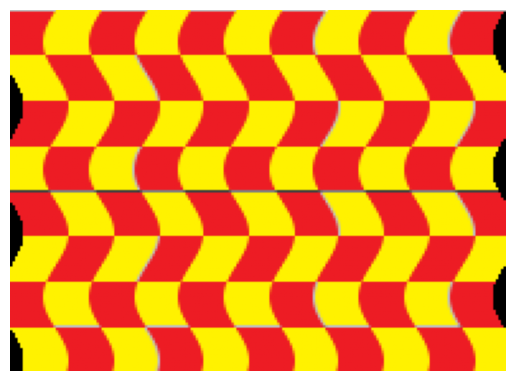


Swirl Filter:



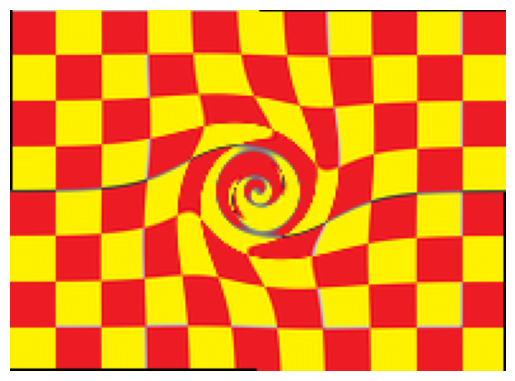


Scatter Filter:



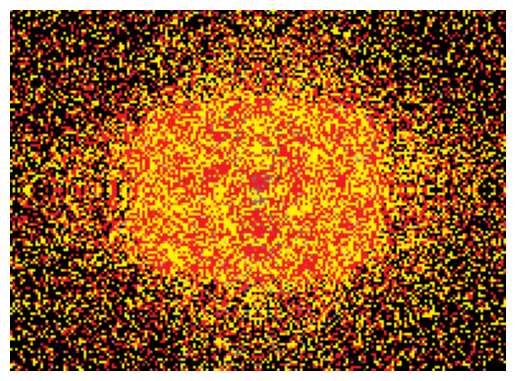


Water Drop Filter:



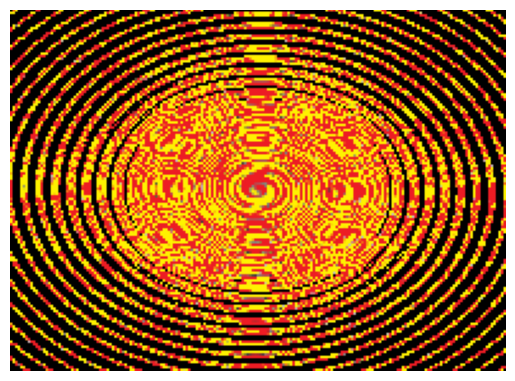


Glass Filter:



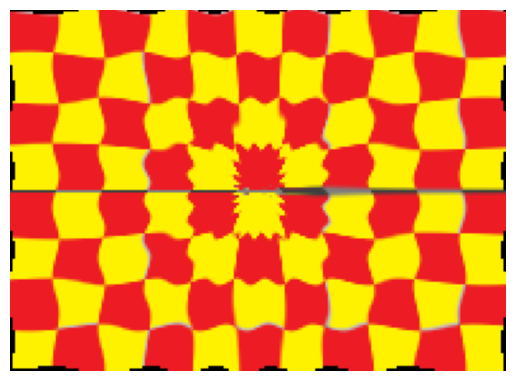

In [ ]:
# This block of code demonstartes the filters on the checkerboard image
tv_check = TV_interference(checkboard)
glass_check = glass(checkboard)
scatter_check = scatter(checkboard)
water_check = water_drop(checkboard)
swirl_check = swirl(checkboard)

print("\nTV Filter:\n")
imshow(tv_check)

print("\nSwirl Filter:\n")
imshow(swirl_check)

print("\nScatter Filter:\n")
imshow(scatter_check)

print("\nWater Drop Filter:\n")
imshow(water_check)

print("\nGlass Filter:\n")
imshow(glass_check)


Original Image



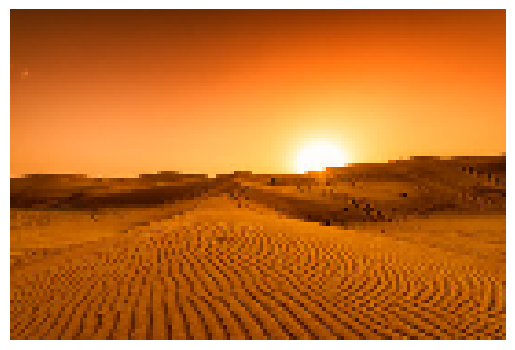


Glass Image



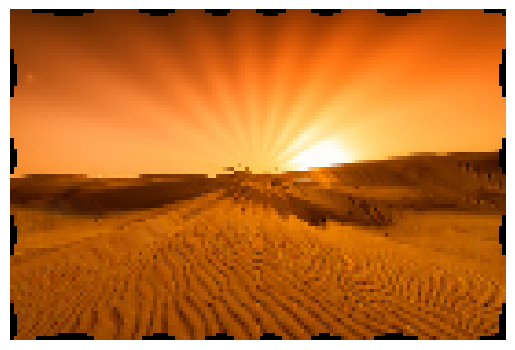


TV Image



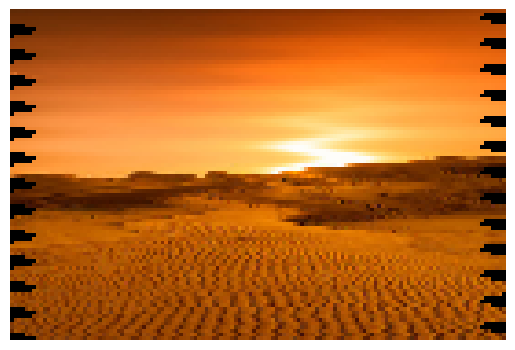


Original Image



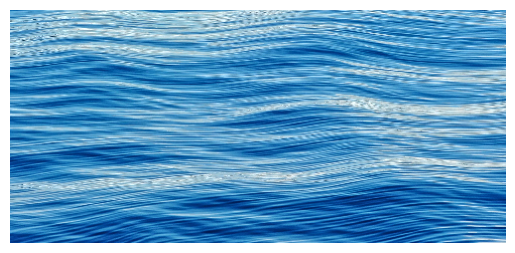


Glass Image



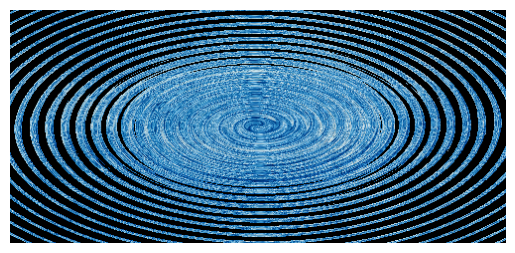


Swirl Image



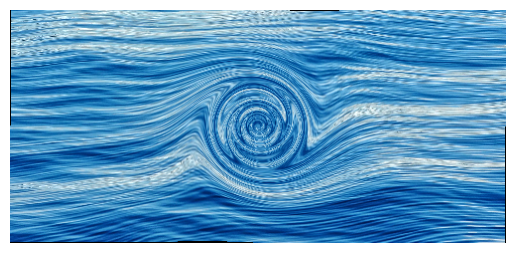


Scatter Image



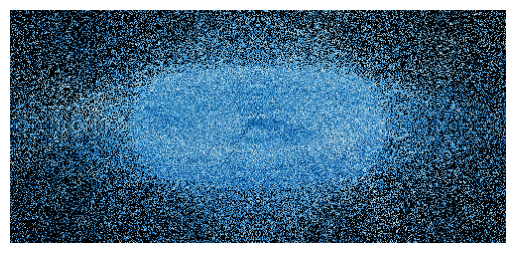

In [ ]:
# This block of code demonstartes the filters with different images
sunset = cv.imread('sunset.jpg',cv.IMREAD_COLOR)[0::4,0::4,[2,1,0]]/255.0
ocean = cv.imread('ocean.jpg',cv.IMREAD_COLOR)[0::4,0::4,[2,1,0]]/255.0
tv_sunset = TV_interference(sunset, 7, 7)
glass_sunset = glass(sunset)
scatter_ocean = scatter(ocean)
water_ocean = water_drop(ocean)
swirl_ocean = swirl(ocean, 10, 20)
print("\nOriginal Image\n")
imshow(sunset)
print("\nGlass Image\n")
imshow(glass_sunset)
print("\nTV Image\n")
imshow(tv_sunset)

print("\nOriginal Image\n")
imshow(ocean)
print("\nGlass Image\n")
imshow(water_ocean)
print("\nSwirl Image\n")
imshow(swirl_ocean)
print("\nScatter Image\n")
imshow(scatter_ocean)